In [1]:
!git clone https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3.git

Cloning into 'TensorFlow-2.x-YOLOv3'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 602 (delta 68), reused 0 (delta 0), pack-reused 482
Receiving objects: 100% (602/602), 70.75 MiB | 30.59 MiB/s, done.
Resolving deltas: 100% (337/337), done.


In [2]:
%cd TensorFlow-2.x-YOLOv3/

/content/TensorFlow-2.x-YOLOv3


In [3]:
!python mnist/make_data.py

Extracting all train files now...
Done!
Extracting all test files now...
Done!
=> /content/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000001.jpg 179,27,193,41,1 242,272,284,314,0 322,187,406,271,2 120,195,232,307,5
=> /content/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000002.jpg 385,295,399,309,0 14,241,36,263,6 327,4,349,26,9 328,59,370,101,6 179,243,221,285,1 172,188,214,230,2 175,45,217,87,1 245,103,357,215,1 40,265,152,377,9
=> /content/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000003.jpg 69,337,91,359,9 215,281,229,295,4 162,296,218,352,2 324,49,352,77,3 49,263,77,291,5 349,173,391,215,3 21,66,133,178,4 284,255,396,367,0
=> /content/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000004.jpg 76,372,98,394,6 134,296,176,338,1 377,269,405,297,7 249,139,277,167,8 348,176,404,232,2 371,31,399,59,2 184,207,240,263,1 255,291,367,403,2 44,124,156,236,0
=> /content/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000005.jpg 211,351,233,373,9 308,18,330,40,0 324,369,338,383,3 228,49,312,133,1
=> /content/TensorFlo

## Model YOLO

### Imports

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, InputSpec, Concatenate, LeakyReLU
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import numpy as np
import shutil
import os

In [5]:
STRIDES = [8, 16, 32]
ANCHORS = [[[10,  13], [16,   30], [33,   23]],
               [[30,  61], [62,   45], [59,  119]],
               [[116, 90], [156, 198], [373, 326]]]
TRAIN_WARMUP_EPOCHS = 1
TRAIN_EPOCHS = 10
TRAIN_LOGDIR = './yolo_checkpoints'
TRAIN_YOLO_TINY = False
TRAIN_CLASSES               = "mnist/mnist.names"
TRAIN_ANNOT_PATH            = "mnist/mnist_train.txt"
TRAIN_LOGDIR                = "log"
TRAIN_CHECKPOINTS_FOLDER    = "checkpoints"
TRAIN_BATCH_SIZE            = 8
TRAIN_INPUT_SIZE            = 416
TRAIN_DATA_AUG              = True
TRAIN_LR_INIT               = 1e-4
TRAIN_LR_END                = 1e-6
TRAIN_WARMUP_EPOCHS         = 2
TRAIN_EPOCHS                = 100
TEST_ANNOT_PATH             = "mnist/mnist_test.txt"
TEST_BATCH_SIZE             = 4
TEST_INPUT_SIZE             = 416
TEST_DATA_AUG               = False
TEST_DECTECTED_IMAGE_PATH   = ""
TEST_SCORE_THRESHOLD        = 0.3
TEST_IOU_THRESHOLD          = 0.45
YOLO_STRIDES                = [8, 16, 32]
YOLO_IOU_LOSS_THRESH        = 0.5
YOLO_ANCHOR_PER_SCALE       = 3
YOLO_MAX_BBOX_PER_SCALE     = 100

### Layers

In [6]:
class Relu6(Layer):
    def __init__(self):
        super(self.__class__,self).__init__()
        self.relu6 = tf.nn.relu6
        
    @tf.function
    def call(self, inputs):
        return self.relu6(inputs)
class BatchNorm(Layer):
    def __init__(self, scale=True, center=True):
        super(self.__class__,self).__init__()
        #self.bn = tf.keras.layers.BatchNormalization(scale=scale, center=center, trainable=True)
        self.bn = BatchNormalization(scale=scale, center=center, trainable=True)

    #@tf.function
    def call(self, inputs, training=True):
        return self.bn(inputs, training=training)
class Convolution2D(Layer):
    def __init__(self, filters, kernel_size, is_activation = True, is_batch_norm = True, downsample=False):
        super(self.__class__,self).__init__()
        
        self.downsample = downsample
        if self.downsample:
            padding = 'valid'
            strides = 2
        else:
            strides = 1
            padding = 'same'
        
        self.is_activation = is_activation
        self.is_batch_norm = is_batch_norm
        self.zero_pad =  ZeroPadding2D(((1, 0), (1, 0)))
        self.conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding=padding, 
                                           use_bias=not is_batch_norm, kernel_regularizer=l2(0.0005),
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                           bias_initializer=tf.constant_initializer(0.))
        
        self.bn = BatchNorm()
        self.act = LeakyReLU(alpha=0.1)
        
    @tf.function
    def call(self, inputs):
        
        if self.downsample:
            x = self.zero_pad(inputs)
#             print(" PAD SHAOE ",x.shape )
            x = self.conv(x)
        else:
            x = self.conv(inputs)
            
        if self.is_batch_norm:
            x = self.bn(x)
        if self.is_activation:
            x = self.act(x)
        
        return x
class AveragePooling(Layer):
    def __init__(self, pool_size):
        super(self.__class__,self).__init__()
        self.avgpool = tf.keras.layers.AveragePooling2D(pool_size=pool_size, padding="SAME")
        
    @tf.function
    def call(self, inputs):
        
        x = self.avgpool(inputs)
         
        return x
class DenseLayer(Layer):
    def __init__(self, units):
        super(self.__class__,self).__init__()

        self.dense = tf.keras.layers.Dense(units=units,
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        
    @tf.function
    def call(self, inputs):
        
        x = self.dense(inputs)
        
        return x
class FlattenLayer(Layer):
    def __init__(self):
        super(self.__class__,self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        
    @tf.function
    def call(self, inputs):
        x = self.flatten(inputs)
        return x
class Residual_Block(Layer):
    def __init__(self, filters):
        super(self.__class__,self).__init__()
        self.conv1  = Convolution2D(filters =   filters, kernel_size = (1, 1))
        self.conv2  = Convolution2D(filters = 2*filters, kernel_size = (3, 3))
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        short_cut = inputs
        x = self.conv1(inputs)
        x = self.conv2(x)
        
#         print(" Residual Output 1", short_cut.shape, x.shape)
        residual_output = self.add([short_cut,x])
#         print(" Residual Output 2", residual_output.shape)
    
        return residual_output
class Upsample(Layer):
    def __init__(self):
        super(self.__class__,self).__init__()
        
    @tf.function
    def call(self, inputs):
        return tf.image.resize(inputs, (inputs.shape[1] * 2, inputs.shape[2] * 2), method='nearest')

In [7]:
class Darknet(Model):
    def __init__(self):
        super(self.__class__,self).__init__()
        self.conv1        = Convolution2D(32, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv2        = Convolution2D(64, (3, 3), is_activation=True, is_batch_norm=True, downsample=True)
        
        self.residual1_1  = Residual_Block(32)
        
        self.conv3        = Convolution2D(128, (3, 3), is_activation=True, is_batch_norm=True, downsample=True)
        
        self.residual2_1  = Residual_Block(64)
        self.residual2_2  = Residual_Block(64)
        
        self.conv4        = Convolution2D(256, (3, 3),is_activation=True, is_batch_norm=True, downsample=True)
        
        self.residual3_1  = Residual_Block(128)
        self.residual3_2  = Residual_Block(128)
        self.residual3_3  = Residual_Block(128)
        self.residual3_4  = Residual_Block(128)
        self.residual3_5  = Residual_Block(128)
        self.residual3_6  = Residual_Block(128)
        self.residual3_7  = Residual_Block(128)
        self.residual3_8  = Residual_Block(128)
        
        self.conv5        = Convolution2D(512,  (3, 3),is_activation=True, is_batch_norm=True, downsample=True)
        
        self.residual4_1  = Residual_Block(256)
        self.residual4_2  = Residual_Block(256)
        self.residual4_3  = Residual_Block(256)
        self.residual4_4  = Residual_Block(256)
        self.residual4_5  = Residual_Block(256)
        self.residual4_6  = Residual_Block(256)
        self.residual4_7  = Residual_Block(256)
        self.residual4_8  = Residual_Block(256)
        
        self.conv6        = Convolution2D(1024, (3, 3),is_activation=True, is_batch_norm=True, downsample=True)
        
        self.residual5_1  = Residual_Block(512)
        self.residual5_2  = Residual_Block(512)
        self.residual5_3  = Residual_Block(512)
        self.residual5_4  = Residual_Block(512)
             
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x) 
        
        x = self.residual1_1(x)        
        
        x = self.conv3(x) 
        x = self.residual2_1(x)
        x = self.residual2_2(x)
        
        x = self.conv4(x)
        x = self.residual3_1(x)
        x = self.residual3_2(x)
        x = self.residual3_3(x)
        x = self.residual3_4(x)
        x = self.residual3_5(x)
        x = self.residual3_6(x)
        x = self.residual3_7(x)
        x = self.residual3_8(x)
        route1 = x
        
        x = self.conv5(x)
        x = self.residual4_1(x)
        x = self.residual4_2(x)
        x = self.residual4_3(x)
        x = self.residual4_4(x)
        x = self.residual4_5(x)
        x = self.residual4_6(x)
        x = self.residual4_7(x)
        x = self.residual4_8(x)
        route2 = x
        
        x = self.conv6(x)
        x = self.residual5_1(x)
        x = self.residual5_2(x)
        x = self.residual5_3(x)
        x = self.residual5_4(x)
        
    
        return route1, route2, x

### Loss functions

In [8]:
def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2] # offset of center position     
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4] # Prediction box length and width offset
    conv_raw_conf = conv_output[:, :, :, :, 4:5] # confidence of the prediction box
    conv_raw_prob = conv_output[:, :, :, :, 5: ] # category probability of the prediction box 

    # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
    y = tf.range(output_size, dtype=tf.int32)
    y = tf.expand_dims(y, -1)
    y = tf.tile(y, [1, output_size])
    x = tf.range(output_size,dtype=tf.int32)
    x = tf.expand_dims(x, 0)
    x = tf.tile(x, [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Calculate the center position of the prediction box:
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    # Calculate the length and width of the prediction box:
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
    pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

    # calculating the predicted probability category box object
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)
def bbox_iou(boxes1, boxes2):
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area
def bbox_giou(boxes1, boxes2):
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    # Calculate the iou value between the two bounding boxes
    iou = inter_area / union_area

    # Calculate the coordinates of the upper left corner and the lower right corner of the smallest closed convex surface
    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    # Calculate the area of the smallest closed convex surface C
    enclose_area = enclose[..., 0] * enclose[..., 1]

    # Calculate the GIoU value according to the GioU formula  
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou
# testing (should be better than giou)
def bbox_ciou(boxes1, boxes2):
    boxes1_coor = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_coor = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left = tf.maximum(boxes1_coor[..., 0], boxes2_coor[..., 0])
    up = tf.maximum(boxes1_coor[..., 1], boxes2_coor[..., 1])
    right = tf.maximum(boxes1_coor[..., 2], boxes2_coor[..., 2])
    down = tf.maximum(boxes1_coor[..., 3], boxes2_coor[..., 3])

    c = (right - left) * (right - left) + (up - down) * (up - down)
    iou = bbox_iou(boxes1, boxes2)

    u = (boxes1[..., 0] - boxes2[..., 0]) * (boxes1[..., 0] - boxes2[..., 0]) + (boxes1[..., 1] - boxes2[..., 1]) * (boxes1[..., 1] - boxes2[..., 1])
    d = u / c

    ar_gt = boxes2[..., 2] / boxes2[..., 3]
    ar_pred = boxes1[..., 2] / boxes1[..., 3]

    ar_loss = 4 / (np.pi * np.pi) * (tf.atan(ar_gt) - tf.atan(ar_pred)) * (tf.atan(ar_gt) - tf.atan(ar_pred))
    alpha = ar_loss / (1 - iou + ar_loss + 0.000001)
    ciou_term = d + alpha * ar_loss

    return iou - ciou_term
def compute_loss(pred, conv, label, bboxes, i=0, CLASSES=TRAIN_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1 - giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    # Find the value of IoU with the real box The largest prediction box
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    # If the largest iou is less than the threshold, it is considered that the prediction box contains no objects, then the background box
    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < YOLO_IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    # Calculate the loss of confidence
    # we hope that if the grid contains objects, then the network output prediction box has a confidence of 1 and 0 when there is no object.
    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss

In [9]:
def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

### Model

In [10]:
class YOLOV3(Model):
    def __init__(self, NUM_CLASS, TRAIN = False):
        super(self.__class__,self).__init__()
        self.NUM_CLASS = NUM_CLASS
        self.TRAIN = TRAIN
        self.darknet = Darknet()
        self.conv1 = Convolution2D(512,  (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv2 = Convolution2D(1024, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv3 = Convolution2D(512,  (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv4 = Convolution2D(1024, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv5 = Convolution2D(512,  (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        
        self.conv_lobj_branch = Convolution2D(1024, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv_lbbox = Convolution2D(3*(NUM_CLASS + 5),  (1, 1), is_activation=False, is_batch_norm=False, downsample=False)
        
        self.conv6 = Convolution2D(256,  (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.upsample1 = Upsample()
         
        self.conv7  = Convolution2D(256, (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv8  = Convolution2D(512, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv9  = Convolution2D(256, (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv10 = Convolution2D(512, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv11 = Convolution2D(256, (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        
        
        self.conv_mobj_branch = Convolution2D(512, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv_mbbox = Convolution2D(3*(NUM_CLASS + 5), (1, 1), is_activation=False, is_batch_norm=False, downsample=False)
        #convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

        
        self.conv12 = Convolution2D(128, (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.upsample2  = Upsample()
        self.conv13 = Convolution2D(128, (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv14 = Convolution2D(256, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv15 = Convolution2D(128, (1, 1), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv16 = Convolution2D(256, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
        self.conv17 = Convolution2D(128, (1, 1), is_activation=True, is_batch_norm=True, downsample=False)    

        self.conv_sobj_branch = Convolution2D(256, (3, 3), is_activation=True, is_batch_norm=True, downsample=False)
    # conv_sbbox is used to predict small size objects, shape = [None, 52, 52, 255]
        self.conv_sbbox = Convolution2D(3*(NUM_CLASS +5), (1, 1), is_activation=False, is_batch_norm=False, downsample=False)

    @tf.function
    def call(self, inputs, training=True):
        
        route_1, route_2, conv  = self.darknet(inputs)    
        x = self.conv1(conv)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        conv_lobj_branch = self.conv_lobj_branch(x)
        conv_lbbox = self.conv_lbbox(conv_lobj_branch)
        
        x = self.conv6(x)
        x = self.upsample1(x)
        
        x = tf.concat([x, route_2], axis=-1)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        
        conv_mobj_branch = self.conv_mobj_branch(x)
        conv_mbbox = self.conv_mbbox(conv_mobj_branch)
        
        x = self.conv12(x)
        x = self.upsample2(x)
        x = tf.concat([x, route_1], axis=-1)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.conv16(x)
        x = self.conv17(x)
        conv_sobj_branch = self.conv_sobj_branch(x)
        conv_sbbox = self.conv_sbbox(conv_sobj_branch)
        
        conv_tensors = [conv_sbbox, conv_mbbox, conv_lbbox]
        
        output_tensors = []

        for i, conv_tensor in enumerate(conv_tensors):
            pred_tensor = decode(conv_tensor, self.NUM_CLASS, i)
            if self.TRAIN:
                output_tensors.append(conv_tensor)
            output_tensors.append(pred_tensor)
        
        return output_tensors

In [11]:
yolo = YOLOV3(10, TRAIN=True)
tert = np.random.rand(1,416,416,3).astype(np.float32)
bert = yolo(tert)

In [12]:
bert[0].shape, bert[1].shape, bert[2].shape

(TensorShape([1, 52, 52, 45]),
 TensorShape([1, 52, 52, 3, 15]),
 TensorShape([1, 26, 26, 45]))

### Dataset

In [13]:
from yolov3.dataset import Dataset
trainset = Dataset('train')
testset = Dataset('test')

In [14]:
steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = TRAIN_WARMUP_EPOCHS * steps_per_epoch
total_steps = TRAIN_EPOCHS * steps_per_epoch

### debug

In [15]:
YOLO_COCO_CLASSES = "model_data/coco/coco.names"
def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2] # offset of center position     
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4] # Prediction box length and width offset
    conv_raw_conf = conv_output[:, :, :, :, 4:5] # confidence of the prediction box
    conv_raw_prob = conv_output[:, :, :, :, 5: ] # category probability of the prediction box 

    # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
    y = tf.range(output_size, dtype=tf.int32)
    y = tf.expand_dims(y, -1)
    y = tf.tile(y, [1, output_size])
    x = tf.range(output_size,dtype=tf.int32)
    x = tf.expand_dims(x, 0)
    x = tf.tile(x, [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Calculate the center position of the prediction box:
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    # Calculate the length and width of the prediction box:
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
    pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

    # calculating the predicted probability category box object
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def bbox_iou(boxes1, boxes2):
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area

def bbox_giou(boxes1, boxes2):
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    # Calculate the iou value between the two bounding boxes
    iou = inter_area / union_area

    # Calculate the coordinates of the upper left corner and the lower right corner of the smallest closed convex surface
    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)

    # Calculate the area of the smallest closed convex surface C
    enclose_area = enclose[..., 0] * enclose[..., 1]

    # Calculate the GIoU value according to the GioU formula  
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

# testing (should be better than giou)
def bbox_ciou(boxes1, boxes2):
    boxes1_coor = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_coor = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left = tf.maximum(boxes1_coor[..., 0], boxes2_coor[..., 0])
    up = tf.maximum(boxes1_coor[..., 1], boxes2_coor[..., 1])
    right = tf.maximum(boxes1_coor[..., 2], boxes2_coor[..., 2])
    down = tf.maximum(boxes1_coor[..., 3], boxes2_coor[..., 3])

    c = (right - left) * (right - left) + (up - down) * (up - down)
    iou = bbox_iou(boxes1, boxes2)

    u = (boxes1[..., 0] - boxes2[..., 0]) * (boxes1[..., 0] - boxes2[..., 0]) + (boxes1[..., 1] - boxes2[..., 1]) * (boxes1[..., 1] - boxes2[..., 1])
    d = u / c

    ar_gt = boxes2[..., 2] / boxes2[..., 3]
    ar_pred = boxes1[..., 2] / boxes1[..., 3]

    ar_loss = 4 / (np.pi * np.pi) * (tf.atan(ar_gt) - tf.atan(ar_pred)) * (tf.atan(ar_gt) - tf.atan(ar_pred))
    alpha = ar_loss / (1 - iou + ar_loss + 0.000001)
    ciou_term = d + alpha * ar_loss

    return iou - ciou_term


def compute_loss(pred, conv, label, bboxes, i=0, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1 - giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    # Find the value of IoU with the real box The largest prediction box
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    # If the largest iou is less than the threshold, it is considered that the prediction box contains no objects, then the background box
    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < YOLO_IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    # Calculate the loss of confidence
    # we hope that if the grid contains objects, then the network output prediction box has a confidence of 1 and 0 when there is no object.
    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss


### Training

In [19]:
!cp /content/drive/My\ Drive/delete/YOLO/CHECK4.zip .

In [20]:
!unzip CHECK4.zip

Archive:  CHECK4.zip
   creating: CHECK4/
  inflating: CHECK4/checkpoint       
  inflating: CHECK4/check4.data-00000-of-00001  
  inflating: CHECK4/check4.index     


In [21]:
yolo.load_weights("CHECK4/check4")

In [22]:
if os.path.exists(TRAIN_LOGDIR): shutil.rmtree(TRAIN_LOGDIR)
writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

validate_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
def validate_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=False)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

    return giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [23]:
optimizer = tf.keras.optimizers.Adam()

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss
        print(" Total Loss ", total_loss)

        gradients = tape.gradient(total_loss, yolo.trainable_variables)
        optimizer.apply_gradients(zip(gradients, yolo.trainable_variables))

        # update learning rate
        # about warmup: https://arxiv.org/pdf/1812.01187.pdf&usg=ALkJrhglKOPDjNt6SHGbphTHyMcT0cuMJg
        global_steps.assign_add(1)
        if global_steps < warmup_steps:# and not TRAIN_TRANSFER:
            lr = global_steps / warmup_steps * TRAIN_LR_INIT
        else:
            lr = TRAIN_LR_END + 0.5 * (TRAIN_LR_INIT - TRAIN_LR_END)*(
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
        optimizer.lr.assign(lr.numpy())

        # writing summary data
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.lr, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()

    return global_steps.numpy(), optimizer.lr.numpy(), giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [24]:
TRAIN_SAVE_BEST_ONLY        = True # saves only best model according validation loss (True recommended)
TRAIN_SAVE_CHECKPOINT       = False

In [25]:
save_directory = "CHECK5/check5"

In [26]:
%cd /content/TensorFlow-2.x-YOLOv3/

/content/TensorFlow-2.x-YOLOv3


In [27]:
best_val_loss = 1000 # should be large at start
for epoch in range(TRAIN_EPOCHS):
    for image_data, target in trainset:
        results = train_step(image_data, target)
        print(" ****  ")
        cur_step = results[0]%steps_per_epoch
        print("epoch:{:2.0f} step:{:5.0f}/{}, lr:{:.6f}, giou_loss:{:7.2f}, conf_loss:{:7.2f}, prob_loss:{:7.2f}, total_loss:{:7.2f}"
              .format(epoch, cur_step, steps_per_epoch, results[1], results[2], results[3], results[4], results[5]))

    
    if len(testset) == 0:
        print("configure TEST options to validate model")
        yolo.save_weights(os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME))
        continue

    count, giou_val, conf_val, prob_val, total_val = 0., 0, 0, 0, 0
    for image_data, target in testset:
        results = validate_step(image_data, target)
        count += 1
        giou_val += results[0]
        conf_val += results[1]
        prob_val += results[2]
        total_val += results[3]
    # writing validate summary data
    with validate_writer.as_default():
        tf.summary.scalar("validate_loss/total_val", total_val/count, step=epoch)
        tf.summary.scalar("validate_loss/giou_val", giou_val/count, step=epoch)
        tf.summary.scalar("validate_loss/conf_val", conf_val/count, step=epoch)
        tf.summary.scalar("validate_loss/prob_val", prob_val/count, step=epoch)
    validate_writer.flush()

    print("\n\ngiou_val_loss:{:7.2f}, conf_val_loss:{:7.2f}, prob_val_loss:{:7.2f}, total_val_loss:{:7.2f}\n\n".
          format(giou_val/count, conf_val/count, prob_val/count, total_val/count))

    # if TRAIN_SAVE_CHECKPOINT and not TRAIN_SAVE_BEST_ONLY:
    #     save_directory = os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME+"_val_loss_{:7.2f}".format(total_val/count))
    yolo.save_weights(save_directory)
    # if TRAIN_SAVE_BEST_ONLY and best_val_loss>total_val/count:
    #     save_directory = os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME)
    #     yolo.save_weights(save_directory)
    #     best_val_loss = total_val/count
    # if not TRAIN_SAVE_BEST_ONLY and not TRAIN_SAVE_CHECKPOINT:
    #     save_directory = os.path.join(TRAIN_CHECKPOINTS_FOLDER, TRAIN_MODEL_NAME)
    #     yolo.save_weights(save_directory)


Streaming output truncated to the last 5000 lines.
 Total Loss  tf.Tensor(4.8361855, shape=(), dtype=float32)
 ****  
epoch:86 step:  109/125, lr:0.000005, giou_loss:   2.32, conf_loss:   0.15, prob_loss:   2.36, total_loss:   4.84
 Total Loss  tf.Tensor(4.7151513, shape=(), dtype=float32)
 ****  
epoch:86 step:  110/125, lr:0.000005, giou_loss:   2.24, conf_loss:   0.06, prob_loss:   2.42, total_loss:   4.72
 Total Loss  tf.Tensor(4.422655, shape=(), dtype=float32)
 ****  
epoch:86 step:  111/125, lr:0.000005, giou_loss:   2.11, conf_loss:   0.19, prob_loss:   2.13, total_loss:   4.42
 Total Loss  tf.Tensor(4.6632023, shape=(), dtype=float32)
 ****  
epoch:86 step:  112/125, lr:0.000005, giou_loss:   2.18, conf_loss:   0.09, prob_loss:   2.39, total_loss:   4.66
 Total Loss  tf.Tensor(4.1823754, shape=(), dtype=float32)
 ****  
epoch:86 step:  113/125, lr:0.000005, giou_loss:   1.92, conf_loss:   0.10, prob_loss:   2.16, total_loss:   4.18
 Total Loss  tf.Tensor(5.085829, shape=(), dt

### Inference

In [28]:
yolo.save_weights("CHECK6/check6")

In [29]:
!zip -r CHECK6.zip CHECK6/

  adding: CHECK6/ (stored 0%)
  adding: CHECK6/check6.index (deflated 81%)
  adding: CHECK6/checkpoint (deflated 41%)
  adding: CHECK6/check6.data-00000-of-00001 (deflated 7%)


In [31]:
infer = YOLOV3(10, TRAIN=False)
tert = np.random.rand(1,416,416,3).astype(np.float32)
bert = infer(tert)

In [32]:
infer.load_weights("CHECK6/check6")

In [30]:
!cp CHECK6.zip /content/drive/My\ Drive/delete/YOLO/

In [33]:
import cv2
import time
import random
import colorsys
import numpy as np
import tensorflow as tf

In [34]:
YOLO_COCO_CLASSES = 'model_data/coco/coco.names'

In [35]:
def draw_bbox(image, bboxes, CLASSES=YOLO_COCO_CLASSES, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != '' else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image
def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious
def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes
def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes


In [36]:
def detect_image(YoloV3, image_path, output_path, input_size=416, show=False, CLASSES=YOLO_COCO_CLASSES, score_threshold=0.3, iou_threshold=0.45, rectangle_colors=''):
    original_image      = cv2.imread(image_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = tf.expand_dims(image_data, 0)

    pred_bbox = YoloV3.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    print(" postprocess_boxes" , len(bboxes))
    bboxes = nms(bboxes, iou_threshold, method='nms')
    print(" nms" , len(bboxes))

    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)

    if output_path != '': cv2.imwrite(output_path, image)
    if show:
        # Show the image
        cv2.imshow("predicted image", image)
        # Load and hold the image
        cv2.waitKey(0)
        # To close the window after the required kill value was provided
        cv2.destroyAllWindows()
        
    return image

In [37]:
# image_path   = "IMAGES/street.jpg"
image_path = 'mnist/mnist_test/000045.jpg'

In [38]:
image = detect_image(infer, image_path, '/content/test1.jpg', input_size=416, CLASSES=TRAIN_CLASSES ,show=False, rectangle_colors=(255,0,0))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 postprocess_boxes 21
 nms 2


In [39]:
import matplotlib.pyplot as plt

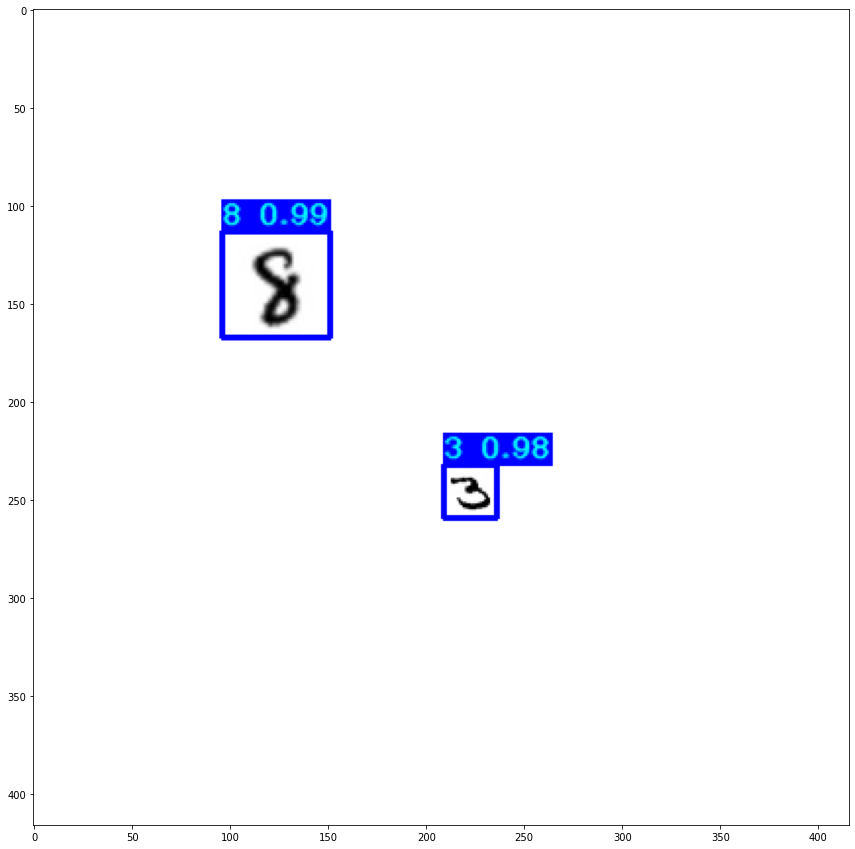

In [40]:
plt.figure(figsize=(30,15))
plt.imshow(image)

In [41]:
from evaluate_mAP import get_mAP

RuntimeError in tf.config.experimental.list_physical_devices('GPU')


In [42]:
get_mAP(infer, testset, score_threshold=TEST_SCORE_THRESHOLD, iou_threshold=TEST_IOU_THRESHOLD)


calculating mAP45...

99.175% = 0 AP  
97.340% = 1 AP  
96.898% = 2 AP  
96.793% = 3 AP  
97.179% = 4 AP  
95.749% = 5 AP  
91.657% = 6 AP  
97.533% = 7 AP  
99.165% = 8 AP  
96.606% = 9 AP  
mAP = 96.810%, 14.98 FPS


96.80962350978155